Simulate age and income

In [43]:
import numpy as np

N = 5000

age = np.random.randint(16, 75, N)

Text(0, 0.5, 'Number of customers')

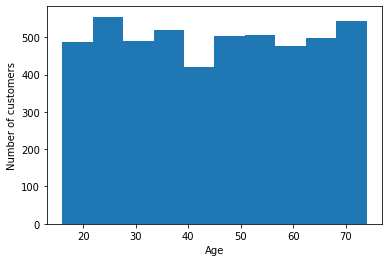

In [47]:
import matplotlib.pyplot as plt

plt.hist(age)
plt.xlabel("Age")
plt.ylabel("Number of customers")

Text(0, 0.5, 'Frequency')

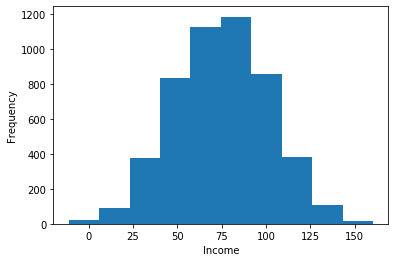

In [49]:
income = age + np.random.normal(30, 20, N)

plt.hist(income)
plt.xlabel("Income")
plt.ylabel("Frequency")

In [72]:
def calculate_class(age, income):
    if age < 30:
        if income >= 130:
            return 2
        elif income >= 100:
            return 1
        else:
            return 0
    elif age < 50:
        if income >= 120:
            return 2
        elif income >= 90:
            return 1
        else:
            return 0
    elif age < 60:
        if income >= 110:
            return 2
        elif income >= 80:
            return 1
        else:
            return 0
    else:
        if income >= 120:
            return 2
        elif income >= 90:
            return 1
        else:
            return 0



In [73]:
def calculate_response(age):
    if age < 50:
        return 1 if np.random.random() < 0.5 else 0
    else:
        return 1 if np.random.random() < 0.3 else 0

In [74]:
_class = list(map(lambda x, y: calculate_class(x, y), age, income))

In [75]:
response = list(map(lambda x: calculate_response(x), age))

Text(0, 0.5, 'Frequency')

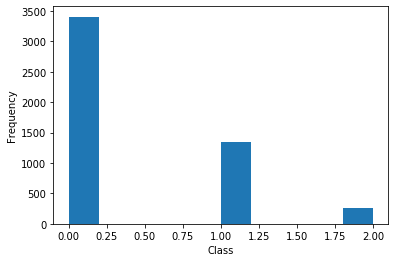

In [77]:
import matplotlib.pyplot as plt

plt.hist(_class)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [78]:
def segmentation(_class, response):
    if _class == 2:
        if response == 1:
            return 2
        else:
            return 1
    elif _class == 1:
        if response == 1:
            return 2
        else:
            return 1
    elif _class == 0:
        if response == 1:
            return 1
        else:
            return 0

In [79]:
segment = list(map(lambda x, y: segmentation(x, y), _class, response))

In [80]:
import pandas as pd

data = {'age': age, 'income': income, 'class': _class, 'response': response, 'segment': segment}
df = pd.DataFrame(data)
df

,age,income,class,response,segment
0,45,99.732532,1,0,1
1,31,35.430627,0,1,1
2,63,94.982713,1,0,1
3,67,61.755892,0,1,1
4,72,108.323442,1,0,1
...,...,...,...,...,...
4995,22,59.116299,0,0,0
4996,27,45.414277,0,1,1
4997,45,42.328414,0,0,0
4998,62,84.824394,0,0,0


Text(0.5, 1.0, 'Segment by age and income')

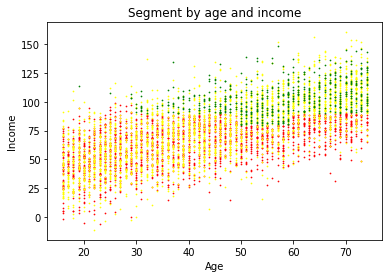

In [103]:
colours = {0: 'red', 1: 'yellow', 2: 'green'}
for segment in [0, 1, 2]:
    df_s = df[df.segment == segment]
    plt.scatter(df_s.age, df_s.income, c=colours[segment], s=0.5)
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Segment by age and income")

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from nyoka import skl_to_pmml

In [82]:
outputs = df['segment']
inputs = df[['age', 'income', 'class', 'response']]

In [83]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.4, random_state=23)

In [84]:
def build_RF_pipeline(inputs, outputs, rf=None):
    if not rf:
        rf = RandomForestRegressor()
    pipeline = Pipeline([
        ("regressor", rf)
    ])
    pipeline.fit(inputs, outputs)
    return pipeline

In [85]:
def RF_estimation(inputs, outputs,
                  estimator_steps=10,
                  depth_steps=10,
                  min_samples_split=None,
                  min_samples_leaf=None):
    # hyper-parameter estimation
    n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=estimator_steps)]
    max_depth = [int(x) for x in np.linspace(10, 100, num=depth_steps)]
    max_depth.append(None)
    if not min_samples_split:
        min_samples_split = [2, 5, 10]
    if not min_samples_leaf:
        min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=random_grid,
                                   n_iter=100, scoring='neg_mean_absolute_error',
                                   cv=3, verbose=1, random_state=42, n_jobs=-1)
    rf_random.fit(inputs, outputs)
    best_random = rf_random.best_estimator_
    print(best_random)
    return best_random

In [86]:
rf = RF_estimation(X_train, y_train, estimator_steps=5, depth_steps=5)
random_forest_pipeline = build_RF_pipeline(X_train, y_train, rf)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [87]:
skl_to_pmml(random_forest_pipeline, ['age', 'income', 'class', 'response'], 'segment',"models/rf_segmentation.pmml")

the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
